# G10 Notebook             AA1

## 1. Notebook description:

#### The aim of this notebook is to train an Agent to balance a cube and a ball over his head one on top of the other. We will  document all the changes and decisions that we will have to make over the process of the training and show how those parameter changes make the training evolve in diferent directions.

#### This team is conformed by:
#### Ivan Anfruns
##### miguelanfrunsortiz@enti.cat
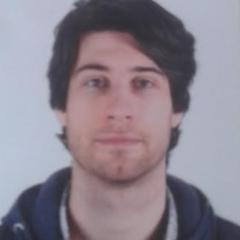

#### Guillermo Esteban
##### guillermoestebanplazas@enti.cat
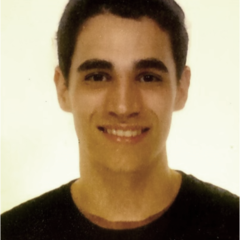

## 2. Case analysis:

#### In the example we have an agent that balances a ball in his head. To do so, he only can rotate his head in the X, Z plane.


    public override void CollectObservations()
    {
        AddVectorObs(gameObject.transform.rotation.z);
        AddVectorObs(gameObject.transform.rotation.x);

        AddVectorObs(ball1.transform.position - gameObject.transform.position);
        
        AddVectorObs(m_BallRb1.velocity);
    }

#### The Agent takes as observations his X and Z rotations and the vector that goes from the center of the head to the center of the ball.

#### The resulting action vector only holds 2 parameters that correspond to the amount of rotation in X and Z. 

#### The values are always clamped to be normalized and then multipled by 2 because that is the maximum amount that an agent can rotate in one frame.

#### Furthermore, the agent will only be able to rotate to a maxium of 0.25 on each angle.

    public override void AgentAction(float[] vectorAction)
    {
        var actionZ = 2f * Mathf.Clamp(vectorAction[0], -1f, 1f);
        var actionX = 2f * Mathf.Clamp(vectorAction[1], -1f, 1f);

        if ((gameObject.transform.rotation.z < 0.25f && actionZ > 0f) ||
            (gameObject.transform.rotation.z > -0.25f && actionZ < 0f))
        {
            gameObject.transform.Rotate(new Vector3(0, 0, 1), actionZ);
        }

        if ((gameObject.transform.rotation.x < 0.25f && actionX > 0f) ||
            (gameObject.transform.rotation.x > -0.25f && actionX < 0f))
        {
            gameObject.transform.Rotate(new Vector3(1, 0, 0), actionX);
        }



#### Once the agent has performed the rotating action, it's time to reward his actions.

#### In this training we are giving every step a positive reward of 0.1 if the agent keeps the ball balanced in his head, but if the ball falls from one of the sides or gets too far from the center of the head, we then give a negative reward of -1 and end the episode.

        if ((ball1.transform.position.y - gameObject.transform.position.y) < -2f ||
            Mathf.Abs(ball1.transform.position.x - gameObject.transform.position.x) > 3f ||
            Mathf.Abs(ball1.transform.position.z - gameObject.transform.position.z) > 3f)
        {
            SetReward(-1f);
            Done();
        }
        else
        {
            SetReward(0.1f);
        }
    }

#### Once an episode is finished we reset the ball and the head to a initial state.

    public override void AgentReset()
    {
        gameObject.transform.rotation = new Quaternion(0f, 0f, 0f, 0f);
        gameObject.transform.Rotate(new Vector3(1, 0, 0), Random.Range(-10f, 10f));
        gameObject.transform.Rotate(new Vector3(0, 0, 1), Random.Range(-10f, 10f));
        m_BallRb1.velocity = new Vector3(0f, 0f, 0f);
        ball1.transform.position = new Vector3(Random.Range(-0.6f, -1.5f), 4f, Random.Range(-1.5f, 1.5f)) +
        gameObject.transform.position;
        
        //Reset the parameters when the Agent is reset.
        SetResetParameters();
    }

## 3. Performance analysis:

## 4. New case proposal: